In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns

import json
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from datasets import list_datasets, load_dataset

In [2]:
# Download ncbi_disease_dataset using huggingface's datasets lib
ncbi_disease_dataset = load_dataset('ncbi_disease')

Reusing dataset ncbi_disease (/Users/vsaurabh/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)


  0%|          | 0/3 [00:00<?, ?it/s]

## Explore the ncbi_disease dataset

In [12]:
ncbi_disease_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

So, the dataset has 5433 train records, 924 validation records and 941 test records

### Explore the train dataset

In [13]:
train_dataset = load_dataset('ncbi_disease', split='train')
val_dataset = load_dataset('ncbi_disease', split='validation')
test_dataset = load_dataset('ncbi_disease', split='test')

Reusing dataset ncbi_disease (/Users/vsaurabh/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)
Reusing dataset ncbi_disease (/Users/vsaurabh/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)
Reusing dataset ncbi_disease (/Users/vsaurabh/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)


In [126]:
train_dataset[-9]

{'id': '5424',
 'tokens': ['A',
  '34',
  'kD',
  'protein',
  'is',
  'immunoreactive',
  'with',
  'the',
  'antisera',
  '-',
  '-',
  'the',
  'protein',
  'is',
  'equivalent',
  'to',
  'that',
  'predicted',
  'for',
  'emerin',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Thus, we can see that the format of dataset consist of `tokens` (which when joined would constitute a sentence),
and the list `ner_tags`, where each value of `ner_tags` has one-to-one mapping with the `tokens`
Here, 0 indicates no disease mentioned, 1 signals the first token of a disease and 2 the subsequent disease tokens.

### Let's do some EDA for the text from which we need find the diseases

### Words frequency analysis

In [130]:
# Get list of all words from train dataset
all_words = [i['tokens'] for i in train_dataset]
len(all_words)

5433

In [30]:
# Get total words and total unique words within our dataset
#total_all_words = sum(all_words, [])

# Get total words after removing stopwords and punctuations
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

total_all_words_ex_stopwords = [i for i in total_all_words if i not in stop_words]
total_all_words_ex_stopwords = [i for i in total_all_words_ex_stopwords if i not in punctuations]
unique_all_words = set(total_all_words)
print(len(total_all_words_ex_stopwords), len(unique_all_words))

77867 9284


In [34]:
# Get the most frequent words
words_counter = Counter()
for word in total_all_words_ex_stopwords:
    if len(word) < 4:
        continue
    words_counter.update([word])
words_counter.most_common(20)

[('gene', 1148),
 ('mutations', 813),
 ('mutation', 666),
 ('patients', 623),
 ('disease', 420),
 ('deficiency', 348),
 ('protein', 329),
 ('normal', 328),
 ('analysis', 312),
 ('families', 308),
 ('syndrome', 302),
 ('chromosome', 293),
 ('human', 293),
 ('found', 290),
 ('cancer', 273),
 ('region', 265),
 ('family', 249),
 ('identified', 244),
 ('G6PD', 242),
 ('associated', 235)]

In [49]:
df.head()

,0
Identification,21
APC2,5
homologue,28
adenomatous,52
polyposis,62


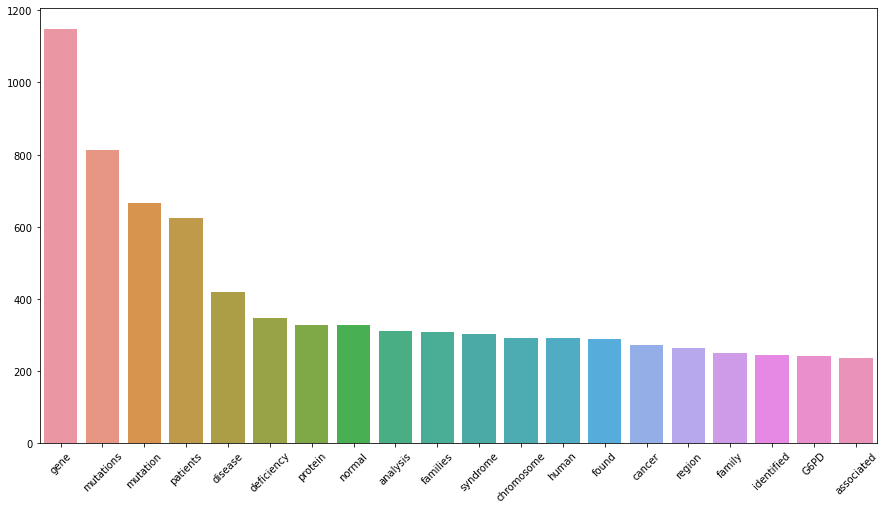

In [53]:
# Plot a histogram for the above data
words_count = words_counter.most_common(20)
word_count = [i[1] for i in words_count]
words = [i[0] for i in words_count]

plt.figure(figsize=(15, 8))
plot = sns.barplot(x=words,y=word_count)
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

### Entity Length Analysis

In [111]:
# Get list of all ner from train dataset
all_tags = [i['ner_tags'] for i in train_dataset]
len(all_tags)

5433

In [117]:
def get_entity_length_frequency():
    len_count_hash = {}
    for tags in all_tags:
        if 1 not in tags or 2 not in tags:
            continue
        start_pos = tags.index(1)
        end_pos = len(tags) - 1 - tags[::-1].index(2)
        length = end_pos - start_pos
        len_count_hash.setdefault(length, 0)
        len_count_hash[length] += 1
    return len_count_hash

In [118]:
len_count_hash = get_entity_length_frequency()

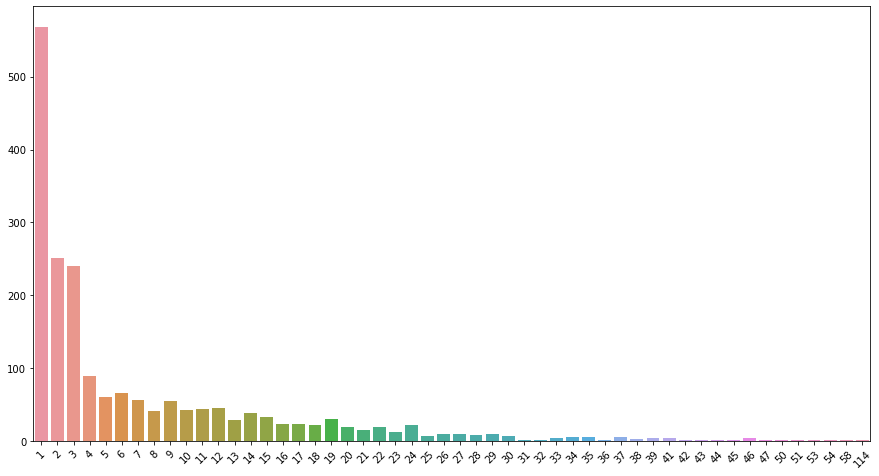

In [121]:
plt.figure(figsize=(15, 8))
plot = sns.barplot(x=list(len_count_hash.keys()),y=list(len_count_hash.values()))
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

From the above plot, we can see that most of the entities have word length less than 4, while few rare ones are longer in length

In [119]:
len(len_count_hash)

52

In [99]:
words_len = [len(i) for i in all_words]
words_len[:3]

[8, 23, 6]

/Users/vsaurabh/miniconda3/envs/thesis/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


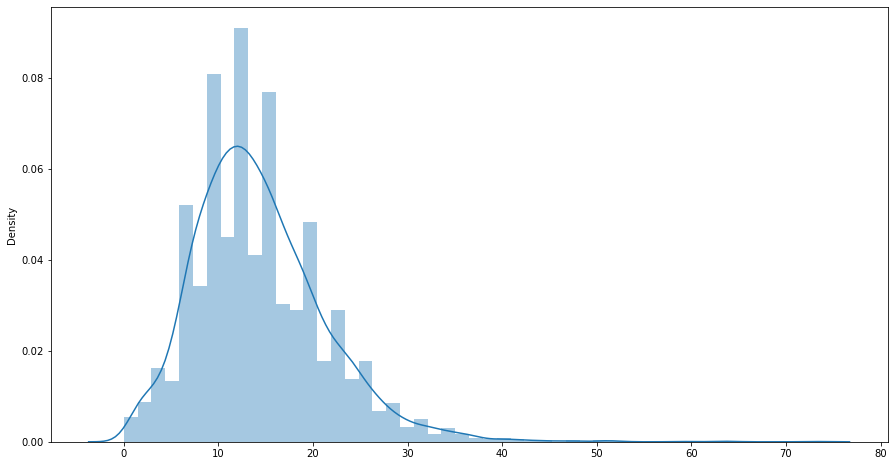

In [100]:
plt.figure(figsize=(15,8))
sns.distplot(words_len)
plt.show()

From the above plot, we can see that majority of the text-content have 20 to 30 words, while some rare content 
also have more than 100 words

Let's try to build a word cloud to see which of the words are more common

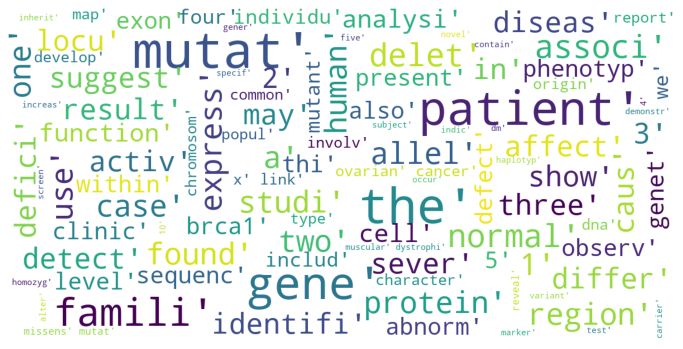

In [101]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(sum(all_words, []))

From the above word-cloud, we can easily see that most of the common words belong to 
medical domain, eg genetic, ovarian, mutation, etc

## Modelling

Let's 1st try to build a simple baseline model based on keras dense layers

In [102]:
def preprocess_text():
    """ preprocess the text
    so that they can be used in modelling
    """
    ps = PorterStemmer()
    result = []
    for words in all_words:
        cleaned_words = [i for i in words if i not in stop_words]
        cleaned_words = [i for i in cleaned_words if i not in punctuations]
        cleaned_words = [ps.stem(i) for i in cleaned_words]
        result.append(cleaned_words)
    return result

In [131]:
# We will first need to encode the input text to give
# a unique id to each word in the entire corpus for input data
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

word_tokenizer = Tokenizer()
#all_words = preprocess_text()
word_tokenizer.fit_on_texts(all_words)

# use the tokeniser to encode input sequence
X_encoded = word_tokenizer.texts_to_sequences(all_words)

# encode val and test and set also
X_val_encoded = word_tokenizer.texts_to_sequences([i['tokens'] for i in val_dataset])
X_test_encoded = word_tokenizer.texts_to_sequences([i['tokens'] for i in test_dataset])

In [132]:
print(len(all_words), len(X_encoded))

5433 5433


As expected, the length of all_words and X_encoded are same

In [105]:
print(len(all_words[0]), len(X_encoded[0]))

8 8


In [106]:
# all unique tokens
len(set(sum(X_encoded, [])))

6293

In [107]:
# Next, we need to pad the texts, because the neural nets expects the vector length
# for each of the input to be the same
# sequences greater than 110 in length will be truncated
from keras.utils import to_categorical

MAX_SEQ_LENGTH = 110
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = pad_sequences(all_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = to_categorical(Y_padded)

# Perform the same operation for validation and test set
X_val_padded = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_val_padded = pad_sequences([i['ner_tags'] for i in val_dataset], maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_val_padded = to_categorical(Y_val_padded)

X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_test_padded = pad_sequences([i['ner_tags'] for i in test_dataset], maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_test_padded = to_categorical(Y_test_padded)


In [108]:
print(len(X_padded), len(Y_padded))
print(len(X_padded[0]), len(Y_padded[0]))

5433 5433
110 110


In [109]:
import gensim.downloader as api

In [127]:
# Load gensim word2vec
wv = api.load('word2vec-google-news-300')

In [148]:
# Simple RNN model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, TimeDistributed, SimpleRNN

rnn_model = Sequential()
rnn_model.add(Embedding(8386, 8, input_length=MAX_SEQ_LENGTH))

rnn_model.add(SimpleRNN(512, return_sequences=True))
rnn_model.add(SimpleRNN(256, return_sequences=True))
rnn_model.add(SimpleRNN(128, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(3, activation='softmax')))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 110, 8)            67088     
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 110, 512)          266752    
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 110, 256)          196864    
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 110, 128)          49280     
                                                                 
 time_distributed_6 (TimeDis  (None, 110, 3)           387       
 tributed)                                                       
                                                                 
Total params: 580,371
Trainable params: 580,371
Non-trainable params: 0
________________________________________________

In [157]:
hist_rnn = rnn_model.fit(X_padded, Y_padded, batch_size=16, epochs=10, validation_data=(X_val_padded, Y_val_padded))

Epoch 1/10
340/340 [==============================] - 32s 93ms/step - loss: 0.1062 - acc: 0.9812 - val_loss: 0.1068 - val_acc: 0.9815
Epoch 2/10
340/340 [==============================] - 32s 94ms/step - loss: 0.1060 - acc: 0.9812 - val_loss: 0.1041 - val_acc: 0.9815
Epoch 3/10
340/340 [==============================] - 33s 96ms/step - loss: 0.1059 - acc: 0.9812 - val_loss: 0.1053 - val_acc: 0.9815
Epoch 4/10
340/340 [==============================] - 33s 97ms/step - loss: 0.1245 - acc: 0.9784 - val_loss: 0.1134 - val_acc: 0.9815
Epoch 5/10
340/340 [==============================] - 33s 98ms/step - loss: 0.1064 - acc: 0.9812 - val_loss: 0.1038 - val_acc: 0.9815
Epoch 6/10
340/340 [==============================] - 37s 108ms/step - loss: 0.1064 - acc: 0.9812 - val_loss: 0.1043 - val_acc: 0.9815
Epoch 7/10
340/340 [==============================] - 35s 104ms/step - loss: 0.1062 - acc: 0.9812 - val_loss: 0.1040 - val_acc: 0.9815
Epoch 8/10
340/340 [==============================] - 35s 10

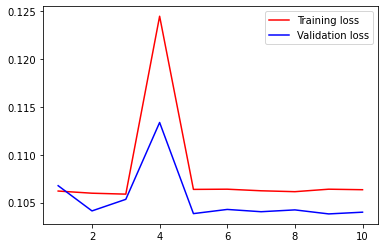

<Figure size 432x288 with 0 Axes>

In [164]:
# Plot training loss vs validation loss
loss = hist_rnn.history['loss']
val_loss = hist_rnn.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.title('Training and validation Loss')
plt.legend()
plt.figure()
plt.show()

In [171]:
# Evaluate the model on test set
results = rnn_model.evaluate(X_test_padded, Y_test_padded, batch_size=8) 

118/118 [==============================] - 2s 20ms/step - loss: 0.1101 - acc: 0.9802


In [172]:
results

[0.11013323068618774, 0.9802241325378418]

Thus, the accuracy on the test dataset is 98.02%

In [158]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, TimeDistributed, LSTM

model = Sequential()
model.add(Embedding(8386, 8, input_length=MAX_SEQ_LENGTH))

model.add(LSTM(512, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(3, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 110, 8)            67088     
                                                                 
 lstm_12 (LSTM)              (None, 110, 512)          1067008   
                                                                 
 lstm_13 (LSTM)              (None, 110, 256)          787456    
                                                                 
 lstm_14 (LSTM)              (None, 110, 128)          197120    
                                                                 
 time_distributed_10 (TimeDi  (None, 110, 3)           387       
 stributed)                                                      
                                                                 
Total params: 2,119,059
Trainable params: 2,119,059
Non-trainable params: 0
___________________________________________

In [159]:
hist_lstm = model.fit(X_padded, Y_padded, batch_size=16, epochs=10, validation_data=(X_val_padded, Y_val_padded))

Epoch 1/10
340/340 [==============================] - 160s 456ms/step - loss: 0.1129 - acc: 0.9783 - val_loss: 0.0868 - val_acc: 0.9815
Epoch 2/10
340/340 [==============================] - 155s 455ms/step - loss: 0.0887 - acc: 0.9812 - val_loss: 0.0914 - val_acc: 0.9815
Epoch 3/10
340/340 [==============================] - 153s 449ms/step - loss: 0.0877 - acc: 0.9812 - val_loss: 0.0855 - val_acc: 0.9815
Epoch 4/10
340/340 [==============================] - 161s 473ms/step - loss: 0.0875 - acc: 0.9812 - val_loss: 0.0850 - val_acc: 0.9815
Epoch 5/10
340/340 [==============================] - 163s 480ms/step - loss: 0.0877 - acc: 0.9812 - val_loss: 0.0867 - val_acc: 0.9815
Epoch 6/10
340/340 [==============================] - 175s 515ms/step - loss: 0.0877 - acc: 0.9812 - val_loss: 0.0854 - val_acc: 0.9815
Epoch 7/10
340/340 [==============================] - 199s 587ms/step - loss: 0.0872 - acc: 0.9812 - val_loss: 0.0874 - val_acc: 0.9815
Epoch 8/10
340/340 [============================

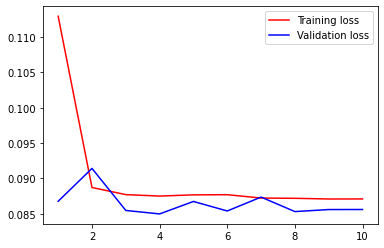

<Figure size 432x288 with 0 Axes>

In [166]:
# Plot training loss vs validation loss
# Plot training loss vs validation loss
loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.title('Training and validation Loss')
plt.legend()
plt.figure()
plt.show()

In [ ]:
# Get the model metrics on test-set
preds = model.predict(X_test_padded)

In [173]:
# Evaluate the model on test set
results = model.evaluate(X_test_padded, Y_test_padded, batch_size=8) 

118/118 [==============================] - 6s 51ms/step - loss: 0.0892 - acc: 0.9802


In [174]:
results

[0.08920785784721375, 0.9802241325378418]

Thus, the accuracy on test set using the LSTM model is 98.02%

In [183]:
# Train a new model with GRU layers

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, TimeDistributed, GRU

model_gru = Sequential()
model_gru.add(Embedding(8386, 8, input_length=MAX_SEQ_LENGTH))

model_gru.add(GRU(512, return_sequences=True))
model_gru.add(GRU(256, return_sequences=True))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(TimeDistributed(Dense(3, activation='softmax')))

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_gru.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 110, 8)            67088     
                                                                 
 gru_6 (GRU)                 (None, 110, 512)          801792    
                                                                 
 gru_7 (GRU)                 (None, 110, 256)          591360    
                                                                 
 gru_8 (GRU)                 (None, 110, 128)          148224    
                                                                 
 time_distributed_15 (TimeDi  (None, 110, 3)           387       
 stributed)                                                      
                                                                 
Total params: 1,608,851
Trainable params: 1,608,851
Non-trainable params: 0
___________________________________________

In [184]:
hist_gru = model_gru.fit(X_padded, Y_padded, batch_size=16, epochs=10, validation_data=(X_val_padded, Y_val_padded))

Epoch 1/10
340/340 [==============================] - 146s 410ms/step - loss: 0.1080 - acc: 0.9784 - val_loss: 0.0916 - val_acc: 0.9815
Epoch 2/10
340/340 [==============================] - 123s 360ms/step - loss: 0.0859 - acc: 0.9811 - val_loss: 0.0931 - val_acc: 0.9815
Epoch 3/10
340/340 [==============================] - 127s 374ms/step - loss: 0.0823 - acc: 0.9811 - val_loss: 0.0888 - val_acc: 0.9815
Epoch 4/10
340/340 [==============================] - 125s 368ms/step - loss: 0.0808 - acc: 0.9812 - val_loss: 0.0896 - val_acc: 0.9814
Epoch 5/10
340/340 [==============================] - 124s 363ms/step - loss: 0.0779 - acc: 0.9814 - val_loss: 0.0891 - val_acc: 0.9815
Epoch 6/10
340/340 [==============================] - 132s 387ms/step - loss: 0.0765 - acc: 0.9815 - val_loss: 0.0885 - val_acc: 0.9813
Epoch 7/10
340/340 [==============================] - 129s 380ms/step - loss: 0.0745 - acc: 0.9818 - val_loss: 0.0905 - val_acc: 0.9811
Epoch 8/10
340/340 [============================

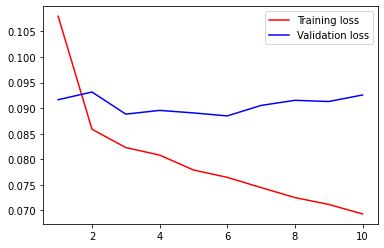

<Figure size 432x288 with 0 Axes>

In [187]:
# Plot training loss vs validation loss
loss = hist_gru.history['loss']
val_loss = hist_gru.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.title('Training and validation Loss')
plt.legend()
plt.figure()
plt.show()

In [185]:
# Evaluate the model on test set
results = model_gru.evaluate(X_test_padded, Y_test_padded, batch_size=8) 

118/118 [==============================] - 6s 48ms/step - loss: 0.0967 - acc: 0.9793


In [186]:
results

[0.09672799706459045, 0.9792773723602295]

Thus, the accuracy on test set using GRU is 97.93%

In [181]:
# Train a new model with Bi-directional LSTM layers

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, TimeDistributed, Bidirectional

model_bilstm = Sequential()
model_bilstm.add(Embedding(8386, 8, input_length=MAX_SEQ_LENGTH))

model_bilstm.add(Bidirectional(LSTM(512, return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(256, return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_bilstm.add(TimeDistributed(Dense(3, activation='softmax')))

model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_bilstm.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 110, 8)            67088     
                                                                 
 bidirectional_9 (Bidirectio  (None, 110, 1024)        2134016   
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 110, 512)         2623488   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 110, 256)         656384    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 110, 3)           771       
 stributed)                                          

In [182]:
hist_bilstm = model_bilstm.fit(X_padded, Y_padded, batch_size=16, epochs=10, validation_data=(X_val_padded, Y_val_padded))

Epoch 1/10
340/340 [==============================] - 389s 1s/step - loss: 0.1013 - acc: 0.9778 - val_loss: 0.0854 - val_acc: 0.9815
Epoch 2/10
340/340 [==============================] - 442s 1s/step - loss: 0.0720 - acc: 0.9812 - val_loss: 0.0881 - val_acc: 0.9815
Epoch 3/10
340/340 [==============================] - 428s 1s/step - loss: 0.0622 - acc: 0.9814 - val_loss: 0.0968 - val_acc: 0.9809
Epoch 4/10
340/340 [==============================] - 416s 1s/step - loss: 0.0570 - acc: 0.9819 - val_loss: 0.1069 - val_acc: 0.9806
Epoch 5/10
340/340 [==============================] - 408s 1s/step - loss: 0.0525 - acc: 0.9822 - val_loss: 0.1151 - val_acc: 0.9815
Epoch 6/10
340/340 [==============================] - 399s 1s/step - loss: 0.0504 - acc: 0.9824 - val_loss: 0.1197 - val_acc: 0.9808
Epoch 7/10
340/340 [==============================] - 408s 1s/step - loss: 0.0478 - acc: 0.9828 - val_loss: 0.1332 - val_acc: 0.9798
Epoch 8/10
340/340 [==============================] - 429s 1s/step - 

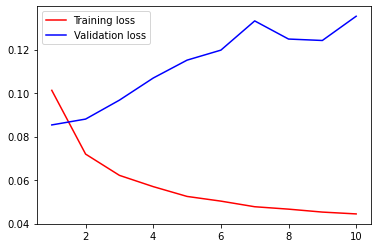

<Figure size 432x288 with 0 Axes>

In [188]:
# Plot training loss vs validation loss
loss = hist_bilstm.history['loss']
val_loss = hist_bilstm.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.title('Training and validation Loss')
plt.legend()
plt.figure()
plt.show()

In [190]:
# Evaluate the model on test set
results = model_bilstm.evaluate(X_test_padded, Y_test_padded, batch_size=8) 

118/118 [==============================] - 14s 118ms/step - loss: 0.1564 - acc: 0.9784


In [191]:
results

[0.15640339255332947, 0.978359580039978]

### Plot comparison graphs for accuracy, loss and time taken for the 4 models

In [192]:
models = ['SimpleRNN', 'LSTM', 'GRU', 'Bi-LSTM']
acuracy = [98.02, 98.02, 97.93, 97.84]
loss = [0.11, 0.09, 0.10, 0.15]
time_per_epoch = [34.3, 152.4, 129.3, 421.8]

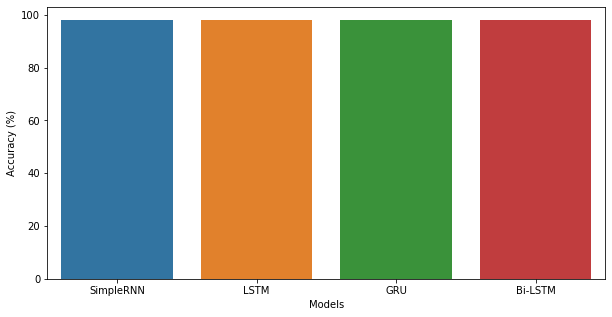

In [201]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=models,y=acuracy)
ax.set(ylabel='Accuracy (%)', xlabel='Models')
plt.show()

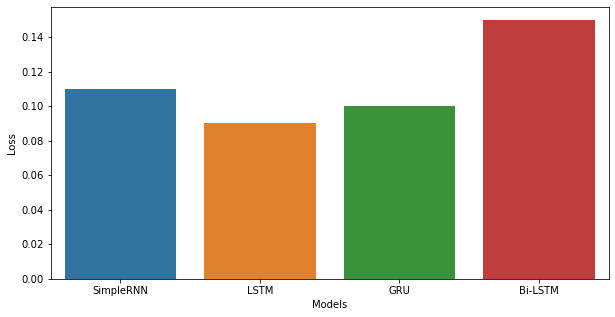

In [203]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=models,y=loss)
ax.set(ylabel='Loss', xlabel='Models')
plt.show()

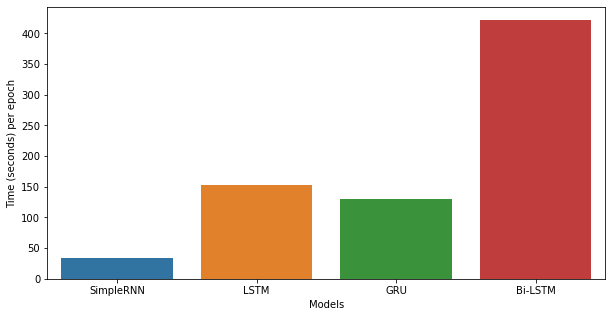

In [209]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=models,y=time_per_epoch)
ax.set(ylabel='Time (seconds) per epoch', xlabel='Models')
plt.show()